# Hamiltonian Monte Carlo with Energy Conserving Subsampling

## Presentation and explanation of an article

Team: 

* Ancellin Eloi
* Eisenbarth Florian
* Foucault Armand
* Garde Joël

Original article: 
[Hamiltonian Monte Carlo with Energy Conserving Subsampling](https://arxiv.org/abs/1708.00955)

* Authors: Khue-Dung Dang and Matias Quiroz and Robert Kohn and Minh-Ngoc Tran and Mattias Villani 
* Year: 2019

In [1]:
%%html
<style>
div.text_cell_render p{
    text-align: justify;
    text-justify: inter-word;
}
</style>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
from sklearn.linear_model import LogisticRegression
from numba import njit
from code_backend import *

# Introduction

## Motivation

To best illustrate what is evoked in this paper let us place ourselves in a *Bayesian* context. Imagine that we have a large dataset $D \in \mathbb{R}^{n * d}$ of size $n$ filled with points in dimension $d$ coming from a law that we do not know how to sample from.

The authors introduce a method to perfom *subsampling* within *Hamiltonian Monte Carlo* (HMC) in a *bayesian* framework. They propose a HMC-within Gibbs method to sample from a posterior distribution of a dataset $D$.

## Objective 

This paper introduces an HMC-within Gibbs method in order to propose samples from a posterior distribution. This form of solution lead them to overcome two major issues, present at the same time, in the domain of posterior simulation algorithms for large amounts of data:  

1. Explore the posterior distribution efficiently when $d$ is large.
2. Keep a computation cost that remains reasonable when $n$ is large.


* Solving 1. is done using HMC methods.
* Solving 2. can be done by subsampling. 

But when we want to solve both 1. and 2. at the same time, it is  more difficult and this is where the interest of the article lies.

### Reasons and issues behind subsampling

The driving cost of HMC is the evaluation of the likelihood in the acceptance ratio and its gradient at each step of the leapfrog integration. Both operations are $O(n)$. The authors's goal is to use subsample of size $m$ to accelerate the computations of the classical HMC to $O(m) << O(n)$ per iteration.

A naive subsampling approach is to disconnect the Hamiltonian from its own dynamics. This leads to a deterioration of the proposals' energy conserving property and then the HMC loses its attractive ability to sample efficiently in high dimension. To tacle this issue, authors introduce a new energy conserving approach to subsample efficiently in HMC. This method keeps the connection intact by estimating both the Hamiltonian and its corresponding dynamics from the same subsample. By doing so, they allow for the scalability of HMC to be maintained along with subsampling.

###  Bayesian Inference

Consider the dataset, its design matrix $D \in \mathbb{R}^{n * d}$ and the labels $Y\in [-1,1]^{n}$. 
We have a model $\Phi_\theta$ that predicts the label: $\Phi_{theta}(x) = \hat y$.


We are interested in finding the distribution of parameters $\theta$ defined by our dataset, that is $P(\theta | D, Y)$. This is the *posterior* distribution.

Given $\theta$ an observation $x$ have probability:

$$
\ell(x|\theta)\ = P(x |\theta)
$$

This is the *likelihood*.

Using the Bayes theorem, we express the posterior distribution with relation to the prior $ \pi(\theta) $ and the likelihood $ \ell(Y|\theta)$:

$$
\pi(\theta|Y) = \frac{\pi(\theta)\ell(Y|\theta)}{\int\pi(u)\ell(Y|u)\mathrm{d} u}\,
$$

But in many cases the normalize constant is not tractable, and we simply write:

$$
\pi(x|Y) \propto \pi(x)\ell(Y|x)\,
$$

We will see how to use $\pi(x)\ell(Y|x)$ inside the Monte Carlo algorithm.

# Related Theory

##  Solving large $d$: Hamiltonian Monte Carlo
Markov Chain Monte Carlo (MCMC) are methods used to produce correlated draws from posterior distribution. In our Case HMC (Hamilton Monte Carlo) is a MCMC which allows to sample from a posterior distribution using the energy conservation property. The key is to construct a Markov chain on an extended state space to which belongs the position $q$ and the velocity $p$ of a the parameters. We shall use the following notations: 

* Position: $ \theta \in \mathbb{R}^{d} $

* Target distribution: $\pi(\theta) \propto e^{-U(\theta)}$

* Momentum: $ p \in \mathbb{R}^{d}$ 

* Potential energy: $ U(\theta) = \ell(\theta)$ where $\ell$ is the log-likelihood

* Kinetic energy: $ K(p) = \frac{p^{T}M^{-1}p}{2}  $

* Extended target density: $\Pi(\theta,p) \propto \exp\{ −U(\theta) − K(p)\} \quad p,q \in \mathbb{R}^{d}$

* The Hamiltonian: $ H(\theta,p) = U(\theta) + K(p) $

The system ($\theta$,p) is assumed to evolve according to Hamilton's dynamics:

$ \forall i \in \mathbb{R^d}$
$$
\begin{align}
\frac{\partial H}{\partial \theta^{t,i}}(\theta^t,p^t) &= \frac{\partial U(\theta^t)}{\partial \theta^{t,i}} = - \frac{dp^{t,i}}{dt} \\
 \frac{\partial H}{\partial p^{t,i}}(\theta^t,p^t) &= \frac{\partial K(p^t)}{\partial p^{t,i}} =  p^{t,i} =\frac{d\theta^{t,i}}{dt}
 \end{align}$$ 


The Hamiltonian dynamics describes the evolution of energy through time. The powerful feature of HMC is that it conserves the energy as times goes on. In practice, we donnot know how to simulate continuous time. Thus, we use a discrete approximation of the dynamics. However, we have to ensure the discretization to be precise enough in order to guarantee this conservation. 

But why do we need to construct such a complicated Markov chain? 

* It turns out that the use of Hamilton dynamics allows us to create a high acceptance probability rate. When a MH proposal is obtained by simulating the dynamics (with a leapfrog integrator for example) it has approximately the same value of the extend taget density as that of the current draw, resulting in a high acceptace rate. In fact, if we consider an ideal discretization $\varphi(\theta,p)$ which is volume preserving and level set invariant we can write this acceptance rate as follows: 
$$ \alpha(\theta, p) = 1 \wedge \frac{\Pi(\varphi{(p,\theta)})}{\Pi{(p,\theta)}}$$
 
The better $\varphi$ approximates the Hamilton dynamics the closer is  $\Pi(\varphi{(p + \Delta p,\theta + \Delta \theta)})$ to $\Pi{(p,\theta)} $ the higher the acceptance ration will be, which is $1$ for the exact dynamics. 

* HMC also avoids slow exploration of the posterior distribution state space. In fact, using HMC allows to propose points which are far from each other by simulating the evolution of Hamiltonian dynamics for a given period of time. Up to a point, the longer the integration time is, the more effectively the dynamics explores the posterior distribution.

### The integrator

In practice we simulate the dynamics thanks to a numerical integrator. In our case, we use the Leapfrog integrator, defined by the following scheme: given an arbitrary small step size $h$, a number of steps $L$, the Leapfrog reads (for $k \in [1, L]$) :


$$
\begin{align}
p^{\frac{k+1}{2}} &= p^k - (\frac{h}{2}) \nabla U(\theta^k) \\
\theta^{k+1} &= \theta^k + h M^{-1}p^{\frac{k+1}{2}} \\
p^{k+1} &= p^{\frac{k+1}{2}} - (\frac{h}{2})\nabla U(\theta^{k+1})
\end{align}$$

For a given integration length, the larger the steps are, the fewer are required. However, the quality of the integration goes down, resulting in a lower acceptance rate. On the contrary, smaller step sizes typically require larger integration times to achieve the same integration length, but the proposals have a higher acceptance rate.  
  
So we can see that there is a trade-off between the stepsize $h$ and the numbers of steps $L$. We also need to compute the gradient of the log-posterior $ \nabla U(\theta^t)$ at each step.

Computing a gradient in high dimension can be prohibitive if an application have limited resources. 
The paper proposes methods to address this issue.


## Solving large $n$ using subsampling

In this article a subsampling is used to speed up computations. In fact, a subset of data is used to compute both the dynamics and the subsequent MH correction performed when deciding to accept a proposal. The article proposes to build a HMC-within-Gibbs algorithm which consist in two main steps :

* Sampling small subset of data with a pseudo marginal step.

* Sampling parameters using HMC dynamics and the MH correction based on the curent subset of the data.

The authors propose two different ways of calculating an estimator of the Likelihood to use in their HMC-within-Gibs algorithm:

1. <ins>First version</ins>

They  use a slightly biased likelihood estimator and show that the algorithm targets a perturbed posterior which gets close to the true posterior density as the subsample size and the number of observations of the data set become large.
 
2. <ins>Second version</ins>

They use an unbiased but possibly negative likelihood estimator which allows them to obtain simulation consistent estimators of the posterior expectation of any function of the parameters.

## Pseudo-marginal MCMC

Pseudo-marginal MCMC is a method that can be used when the target posterior distribution $\pi$ of some parameter $\theta$ is not known analytically, but an *unbiased* and *non-negative* estimator of it is available. Assume we have a dataset of $n$ observations $y$ ; the posterior distribution of $\theta$ given $y$ reads:

$$
\pi(\theta) \propto L(\theta)p_{\Theta}(\theta) \qquad \qquad (1)
$$

Where $L$ is the likelihood of $\theta$ ($L(\theta) = p(y|\theta)$) and $p_\Theta$ is the prior on $\theta$. In the Pseudo-marginal framework, we suppose the posterior to be untractable, but we are able to estimate it by using an unbiased estimator of the likelihood $\hat{L}_m$ built on a set of $m$ auxiliary variables $u$ distributed according to a distribution $p_U$. This allows to write an extended estimator of the posterior: </p>
    
$$
\bar{\pi}(\theta, u) \propto \hat{L}_m(\theta)p_{\Theta}(\theta) p_U(u) \qquad \qquad (2)
$$

The unbiasedness assumption on $\hat{L}_m$ has to be understood as $E_{p_U}[\hat{L}_m(\theta)] = L(\theta)$, which in turn implies that we can obtain $\pi(\theta)$ by integrating $\bar{\pi}(\theta, u)$ with respect to $p_U$, for all $\theta$ in $\Theta$. Note that in the above formula, the dependence of $\hat{L}_m$ on $u$ is not explicited for convenience. </p>

In order to obtain samples from (1), it suffices to use a Metropolis-Hastings Algorithm targetting (2), drawing alternatively $\theta$'s and $u$'s, and output the samples drawn for $\theta$. The unbiasedness of $\bar{\pi}$ assures us that these samples are distributed according to $\pi$. Now in the Bayesian framework, a natural way of estimating the likelihood would be to use the observations of the dataset $y$ as auxiliary variables. But it turns out that this approach can be prohibitively costly when the size of $y$ is very large, since in practice, the computations should be done at each iteration of the MCMC algorithm. </p>  

To circumvent this issue, one usual trick is to use subsampling ; that is draw a random subsample $u$ from the dataset, according to some distribution $p_U(u)$, and compute the estimated likelihood on this reduced dataset. However, there are common pitfalls related to "naive" subsampling, that are detailed in the first part. We shall explain here in which way the authors cleverly overcome these issues. </p>

# Hamiltonian Monte Carlo within Gibbs

We started with the target distribution :
$$
\begin{align}
\pi(\theta) \\
\theta \; {\text{model parameters}}
\end{align}
$$

To handle large $d$ and HMC, it was extended to:

$$
\begin{align}
\pi(\theta, p) \\
\theta \; {\text{model parameters}}\\
p \; {\text{momentum}}\\
\end{align}
$$

To handle large $n$ and a Pseudo-marginal approach, it was further extended to:

$$
\begin{align}
\bar \pi(\theta, p, u) \\
\theta \; {\text{model parameters}} \\
p \; {\text{momentum}}\\
u \; {\text{subsampling indices}} \\
\end{align}
$$
and $\bar \pi$ denote the estimator of $\pi$.

The Monte Carlo algorithm to sample from $\bar \pi (\theta, p, u)$ described by Dang et al. use a "HMC within Gibbs" method, that is making alternatively two steps at each iteration (Gibbs) ; the first one consists in (sub)sampling auxiliary variables (for estimating posterior distribution target) and the second one is the simulation of the Hamiltonian dynamics (HMC). One iteration of the algorithm can be summarized as :  


1. sample $\;u\: | \theta, p, y$ - Pseudo-marginal auxiliary subsample update.
2. sample $\;\theta, p\:| u, y$ - HMC update given the new subsample $u$.

In this part, we explain their approach. 

## First step : Auxiliary variables subsampling

At each iteration, we first draw randomly $u$, the subsample base for the estimate. This vector contains the indices of the observations from the dataset that are going to be used. The size $m$ of $u$ is a carefully chosen hyper-parameter. 

### Subsample size

In their paper, Dang et al. choose a subsample size $m$ to minimize the computational complexity of their algorithm and keep the ability to efficiently explore the target distribution. An $m$ that is too small induces a high variance of the likelihood estimator, and tends to overestimate the likelihood at the current position of the markov chain, making the proposals very unlikely to be accepted. Conversely, choosing an $m$ too large would make the computations of the likelihood estimator too costly and the objective of the paper would fail.

The authors base their choice of $m$ on some previous research. We know that if the subsamples are drawn independently through MCMC iterations, the optimal subsample size $m$ (minimizing the computational time) is such that the variance of the likelihood estimator is approximately $1$. However, the same computational time can be achieved with substantially higher variance in the likelihood estimator, if we induce some dependence between the subsamples through iterations$^{[1]}$.
    
The intuition behind this is that with correlation between subsamples, the estimated likelihoods will also be correlated through iterations. Therefore the acceptance ratio which is based on this estimation will be maintained high, and the proposals will be likely to be accepted. This avoids to waste huge amount of computational time to compute steps that are usually rejected.

With the difference estimator, the size of the subsample is set to $n^{0.5}$.

### Correlated draws
In order to maintain a high acceptance ratio (see (3)) and avoid to have the subsample stuck at some point, we induce high correlation between the subsamples by dividing the subsample into $G$ blocks and updating only one block at each iteration$^{[1]}$. It is proved that the higher the number of blocks, the higher the correlation $\rho$ between following subsamples ($\rho \simeq 1 - 1/G$). The underlying distribution can be described the following way: </p>

* We draw randomly one block among the $G$ blocks, and then draw $u'$ (proposed update for the chosen block) amongst $y$ according to the proposition law $p_U$

* We set $u_t = u'$ with probability $\alpha_u$ and $u_t = u_{t-1}$ with probability $1 - \alpha_u$, where

$$
\alpha_u = \min \left(1, \frac{\hat{L}_m (\theta_{t-1}, u')}{\hat{L}_m (\theta_{t-1}, u_{t-1})} \right) \qquad \qquad (3)
$$

In the above ratio, the relatively small size of $u_{t-1}$ tends to make the denominator somewhat overestimated, due to the high variance of the estimator, which risks to make the ratio close to $0$. We can see that the high correlation between $u'$ and $u_{t-1}$ corrects this effect by naturally making the numerator close to the denominator.


In [3]:
@njit(fastmath=True)
def block_update(u, G, x):
    """
    block-update of u considering G blocks.
    To be used with the difference estimator

    """
    m, n = u.shape[0], x.shape[0]
    group_size = m // G
    #step 1: random mask that will change 1 block of (size(u) / G) variable.
    replace = np.arange(m) < group_size
    replace = np.random.permutation(replace)
    
    #step 2: replace with new indices only where masked.
    new_u = np.random.choice(n, u.shape, replace=False)
    u = np.where(replace, new_u, u)
    return u

In [4]:
def poisson_update(u, m, lmbda, kappa):
    """
    update of u for the poisson estimator.
    m is the size of the base batch.
    only kappa list of batches are updated to correlate u's.
    correlation ~ 1 - kappa / lmbda
    returns a list of list of batches. (lambda * xi_lambda batches)
    """
    n = x.shape[0]
    indices_to_update = np.random.choice(lmbda, kappa, replace=False)

    xi = np.random.poisson(1, kappa)
    for idx in indices_to_update:
        u[idx] = []
        for j in range(xi):
            batch = np.random.choice(n, m, replace=False)
            u[idx].append(batch)
    return u

## Second step : Hamiltonian Monte Carlo

In the HMC framework, we extend the dimension of the parameter vector $\theta$ by adding a continuous momentum random vector $p$ with the same dimension as $\theta$. The extended target defined in the Pseudo-Marginal method is thus rewritten as: </p>

$$
\bar{\pi}_m(\theta, p, u) \propto exp\left(-\hat{H}(\theta, p)\right)p_U(u), \quad \hat{H}(\theta, p) := \hat{\mathcal{U}}(\theta) + \mathcal{K}(p)
$$

Where:

$$
\hat{\mathcal{U}}(\theta) = -\log \hat{L}_m(\theta) - \log p_{\Theta}(\theta) \ \ \text{and} \ \ \mathcal{K}(p) := \frac{1}{2}p^t M^{-1} p
$$

For some positive-definite matrix $M$, (note that the marginal distribution of $p$ has the density of a gaussian vector). $\hat H$ denotes the fact that we use an estimator based on the subsample to compute $H$. 

For one HMC step (given a subsample $u$), we use the Hamiltonian dynamics described in the introduction of this document. We use the leapfrog integrator as the discrete simulator of the Hamiltonian dynamics. Starting at $(\theta_{t-1}, p^0)$, with $p^0 \sim \mathcal{K}(p)$, we make $L$ leapfrog moves to reach $(\theta^L, -p^L)$ (we flip the momentum), and then set $(\theta_t, p_t) = (\theta^L, -p^L)$ with probability: </p>

$$
\alpha_{\theta,p} = \min \left(1, exp\left(-\hat{H}(\theta^L, -p^L) + \hat{H}(\theta_{t-1}, p^0)\right)\right) \qquad \qquad (4)
$$

Or set: $(\theta_t, p_t) = (\theta_{t-1}, p^0)$ with probability $1 - \alpha_{\theta,p}$. 

Note that the energy conservation property of the Hamiltonian dynamics is well approximated here because we estimate the Hamiltonian on the same subsample in (4) as in the computations of the dynamics (no update of $u$ in between), which requires the gradient of $\hat{\mathcal{U}}(\theta).$ This allows the proposal to almost remain on the same $\hat{H}-$level set as the current position, which results in a high acceptance ratio in (4). </p>

### Choice of the matrix M

In our lecture, $M$ was set to $I_d$. However, one can make more sensible choice$^{[2]}$. Choosing $M = \Sigma^{-1}$ where $\Sigma$ is the covariance matrix of $\theta$ is equivalent to performing the integration in a space where the variables $\theta$ are independent.

We found the paper to be lacking in this regard. They say to choose $M=−\Sigma^{-1}(\theta)$ where $\Sigma$ is the hessian of the posterior, and one page later $M=\Sigma^{-1}(\theta)$ so what is it really?

If you consider the posterior to be gaussian with covariance matrix $\Sigma$ and logpdf proportional to $-\frac{1}{2}\theta\Sigma^{-1}\theta$, then the hessian $H_{posterior}$ whould be $-\Sigma^{-1}$ , and you whould choose $M = - H_{posterior} = \Sigma^{-1}$ where $H$ is the hessian of the posterior, and this is what we use in our implementation.

Another interesting observation not highlighted in the paper is that we can obtain $M$ for "free". Indeed, we already compute $H_{loglikelihood}$ for the estimator. $H_{posterior}$ is directly obtainable from $H_{loglikelihood}$. 

In our implementation, we donnot use $M$, but $L$, where $M = LL^T$ is the Cholesky decomposition of $M$. This has multiples benefits:

* To sample $p$, you need $L$ through a scipy function as recomputinh it whould be expensive.
* To compute $\mathcal{K}(p) := \frac{1}{2}p^t M^{-1} p$, you simply compute $||L^{-1} p||$ by solving a triangular system, which is fast.
* Similarly,  computing $M^{-1} p$ in the Leapfrog by solving triangular systems on $L$, makes it faster and more stable.

In [5]:
def hmc_ec_kernel(u, q, p_est, e, L, Hs, i):
    """kernel for the energy conservative HMC
    
    Parameters:
    ----
    
    u: auxiliary variable. Indexes of the current subsample.
    q: main variable. Parameter we are trying to sample.
    p_est: tuple (p*, grad(L)(p*), hessian(L)(p*)). Precomputed variable used to compute the estimator.
    e: step size in the leapfrog.
    L: Total lenght of the leapfrog integrator.
    Hs: Error term in the dual averaging.
    i: iteration number. Used to define the dual averaging.
    """
    
    #pseudo-step: auxiliary variable subsampling
    u_prime = block_update(u.copy(), G)
    log_uniform = np.log(np.random.uniform(0,1))
    log_alpha_pseudo = hat_diff(u_prime, q, *p_est) - hat_diff(u, q, *p_est)
    do_accept = log_uniform < log_alpha_pseudo
    if do_accept:
        u = u_prime
    
    #hamiltonian step
    p = multivariate_normal(L) #to do: optimize the inversion away.
    qL, pL = leapfrog(q.copy(), p.copy(), u, p_est, e, np.minimum(int(lmbda/e)+1, 10), L)
    log_uniform = np.log(np.random.uniform(0,1))
    log_alpha_hmc = - H(qL, pL, u, p_est, shrink, L) + H(q, p, u, p_est, shrink, L)
    do_accept = log_uniform  < log_alpha_hmc
    if do_accept:
        q = qL
    
    #dual averaging 
    #exponential averaging of the errors
    #as to be re-initialized each time we update H.
    #https://arxiv.org/abs/1111.4246
    Hs_next = np.exp(log_delta) - np.minimum(np.exp(log_alpha_hmc), 1.0)
    Hs = (1 - (1/(i + t0))) * Hs + (1/(i + t0)) * Hs_next
    log_e = nu - (i**(0.5) / gamma) * Hs
    e_next = i**(-kappa) * log_e + (1 - i**(-kappa)) * np.log(e)
    e = np.exp(e_next)
    return u, q, e, Hs, i+1.0, log_alpha_hmc

### Dual Averaging

Dual averaging was first proposed in a paper by Hoffman and Gelman$^{[3]}$ (the famous no-U-turn sampler). It is a method to automatically set the step size by solving an unconstrained optimization problem, given a target acceptance ratio $\delta$.
The paper is not clear on this topic. They claim to follow Hoffman and Gelman and set $\delta=0.8$, but the original setting is $0.65$. What is more, they report in their experiments an actual results of $\delta_{exp} = 0.97$. Something is not clear here.

We set the dual avering scheme to target $\delta = 0.65$ and did find so in our experiments.

# Estimation of the likelihood

In order to sample from the joint target posterior distribution described in the Pseudo-Marginal section, we need to estimate the likelihood function that appears in the expression of the posterior. In their paper, Dang et al. use two distinct estimators. What is more, we need the estimator to be efficient to compute on a subsample.

### An efficient estimator with slightly perturbed posterior

The first estimator used in the paper is the one proposed by Quiroz and al. in 2019$^{[4]}$. It estimates the log-likelihood $\ell(\theta) = log L(\theta)$ by the *difference estimator*:</p>

$$
\hat{\ell}_m(\theta) = \sum_{k=1}^n q_k + \hat{d}_m (\theta) \qquad \qquad (5)
$$

Where:

$$\hat{d}_m(\theta) = \frac{1}{m} \sum_{i=1}^m \frac{l_{u_i}(\theta) - q_{u_i}(\theta)}{\omega_{u_i}} \quad (6)$$

With:

$\omega_{u_i}$ corresponding to the probability of drawing $u_i \in \{1, \ldots, n\}$ for the $i$-th subsample. 
In practice, we set:
$\omega_k = 1/n$ for all $k$ in $\{1, \ldots, n\}$, and :
$$\hat{d}_m(\theta) = \frac{n}{m} \sum_{i=1}^m l_{u_i}(\theta) - q_{u_i}(\theta)$$ 


$q_k(\theta)$ is the second order Tailor expansion of $\ell_k(\theta)$ around a fixed central value $\theta^*$ ; the $q_k$ are reffered to as *control variates*, and their sum is meant to approximate $\ell(\theta)$. It requires to compute $\ell(\theta^*)$, its gradient and hessian only once based on the whole dataset and then the sum can be computed in $O(d)$.


To intuitively derive this estimator, you need to first take a second order estimation of the likelihood, $\sum q_k$. Then you can see how wrong is your estimate on the current batch by computing the difference $\hat d$. Finally, you correct your first guess by taking the difference between the mean second order apporoxiation and the mean of the difference. 


This estimator is proved to be unbiased for $l(\theta)$ (its expectation with respect to $u$ is equal to $l(\theta)$). The authors estimate its variance by </p>

$$
\hat{\sigma}^2_m(\theta) = \frac{n^2}{m^2} \sum_{i=1}^m \left(d_{u_i}(\theta) - \bar{d}_{u}(\theta)\right)^2, \qquad \text{with} \ d_{u_i}(\theta) = l_{u_i}(\theta) - q_{u_i}(\theta), \ \text{and $\bar{d}_u$ is the average of $d_{u_i}$'s over $u$} 
$$

Based on this estimator, we estimate (again, according to Quiroz et al, 2019) $L(\theta)$ by

$$
\hat{L}_m(\theta) = \exp \left( \hat{l}_m(\theta) - \frac{1}{2}\hat{\sigma}_m^2(\theta) \right) \qquad \qquad (7)
$$

Unfortunately, this estimator is not unbiased with respect to $u$ (it would be if we replaced the estimation of $\sigma^2$ by its actual value, but it is unknown in practice). Therefore, the distribution $\bar{\pi}_m(\theta, u)$ targetted by the HMC-ES algorithm does not have $\pi(\theta)$ for marginal but a perturbed approximation of it.

For the HMC part of the algorithm, we also need to estimate the gradient of $\hat{\mathcal{U(\theta)}} = -\log{\hat{L}_m(\theta)}$. By looking at (6), we can see that this requires to estimate $\nabla \hat{l}_m(\theta)$ and $\nabla \hat{\sigma}^2_m(\theta)$. By observing that $\nabla q_{k}(\theta) = \nabla l_k(\theta^*) + H_k(\theta^*)(\theta - \theta^*)$ (with $H_k(\theta)$ the hessian matrix of $l_k$ at point $\theta$), it is straightforward to compute both $\nabla \hat{l}_m(\theta)$ and $\nabla \hat{\sigma}^2_m(\theta)$.



In [6]:
@njit(fastmath=True)
def control_v(q, qs, prim, grad, hess):
    """ 
    2nd order approximation of the loglikelihood at qs, evaluated at q
    given the precomputed primal, gradient and hessian.
    """
    d = q - qs
    return prim + grad @ d + 0.5 * d.T @ (hess @ d)

In [7]:
@njit(fastmath=True)
def hat_diff(u, q, qs, prim, grad, hess, x, y):
    """
    log-likelihood difference estimator.
    u: auxiliary variable. Indexes of the current subsample.
    q: main variable. Parameter we are trying to sample.
    (qs, prim, grad, hess): tuple (p*, f(p*), grad(L)(p*), hessian(L)(p*)). Precomputed variable used to compute the estimator.
    x, y: the dataset.
    """

    n = x.shape[0]
    m = u.shape[0]
    
    diff = log_likelihood(y[u], x[u], q) - control_v(q, *precompute(y[u], x[u], qs))
    total = control_v(q, qs, prim, grad, hess) + (n / m) * diff
    return total

### The Block-Poisson estimator

Dang et al. also propose an implementation using the block-Poisson estimator, first introduced in a paper by Quiroz et al. in 2016$^{[5]}$.

This estimator is constructed the following way: we first sample independently $\lambda$ (pre-defined integer) variables $\chi_1, \dots \ \chi_{\lambda}$, each one following a Poisson distribution $Pois(1)$. Then we estimate the likelihood according to

$$
\hat{L}_m(\theta) = \exp \left( \sum_{i=1}^n q_k(\theta) \right) \prod_{l=1}^{\lambda} \xi_l, \qquad \xi_l = \exp \left( \frac{a + \lambda}{\lambda} \right) \prod_{h=1}^{\chi_l} \left( \frac{\hat{d}_m^{(h,l)}(\theta) - a}{\lambda} \right) \qquad \qquad (8)
$$

where the $\hat{d}_m^{(h,l)}(\theta)$ are computed for $l = 1, \dots, \lambda$ and $h = 1, \dots, \chi_l$ according to (6) (we need to have a sample $u$ of size $m$ for each $l = 1, \dots, \lambda$ and $h = 1, \dots, \chi_l$), and $a$ is a real number. 

If the difference estimator was non-negative but biased, this estimator is unbiased for $L(\theta)$ (by integrating with respect to $U$), but it is not almost surely positive and cannot be used out of the box for targetting a proper probability measure. Nevertheless, it is possible to use the estimator for another problem, that is approximating $E_{\pi}[\psi]$ for an arbitrary function $\psi$ (rather than sampling data from distribution $\pi$). This is done by running the HMC-ECS algorithm on the target:

$$
\tilde{\pi}_m(\theta, p, u) \propto |\hat{L}_m(\theta)| p_{\Theta}(\theta) p_U(u) \exp(\mathcal{K}(p))
$$

and then estimate $E_{\pi}[\psi]$ by:

$$
\hat{I}_R = \frac{\sum_{j=1}^R \psi(\theta^{(j)})s^{(j)}}{\sum_{j=1}^R s^{(j)}}
$$

where $s^{(j)}$ is the sign of the estimate at the $j$-th iteration. This approach is inspired by a result obtained by Lyne et al.$^{[6]}$ which states that $E_{\pi}[\psi] = \frac{E_{\tilde{\pi}}[\psi S]}{E_{\tilde{\pi}}[S]}$, with $S(\theta, u) = sign(\hat{L}_m (\theta))$. This implementation of the HMC-ECS algorithm using the Block-Poisson estimator is named *signed* HMC-ECS by the authors.

In [8]:
def log_block_poisson(u, lmbda, a, l, q, qs, prim, grad, hess):
    """ 
    logarithm of block-poisson estimator.
    expects u to be a list of list of vectors of indices.(lambda * xi_lamda)
    lmbda: meta-parameter of the estimator.
    a: meta-parameter of the estimator.
    q: current sample
    qs, prim, grad, hass: pre-computed parameters.
    """
    #fast computation of the sum of qk using the precomputed values.
    qk_sum = control_v(q, qs, prim, grad, hess)
    sum_log_diff = 0

    for ul in u: #for each list, there should be lambda lists.
        for ui in ul: #each sub list is of size Xi_lambda.
            diff = log_likelihood(y[ui], x[ui], q) - control_v(q, *precompute(y[ui], x[ui], qs))
            sum_log_diff += np.log(np.abs((diff - a) / lmbda))

    return qk_sum + (a + lmbda) + sum_log_diff

# Experimental Results

## Problem definition

We are solving a logistic regression problem over the *HIGGS* dataset (https://archive.ics.uci.edu/ml/datasets/HIGGS#). The higgs datasets contains over 11 millions points, but for the purpose of this experiment, we only use 5000. Each point have 21 features. (The original dataset has 28 features, but the last 7 are high-level features of the first 21, and we believe they should not be included in our experiement).

In [9]:
# In order to run the notebook, please download the data to the following link : https://archive.ics.uci.edu/ml/datasets/HIGGS#
# Note that you should name the data file HIGGS.csv
#data = pd.read_csv("HIGGS.csv.gz",sep=",", header=None, nrows=100, usecols=[i for i in range(22)]).to_numpy()
data = pd.read_csv("HIGGS.csv",sep=",", header=None, nrows=5000, usecols=[i for i in range(22)]).to_numpy()
x = data[:,1:]
y = data[:,0]
n_sample = x.shape[0]
q = np.ones(x.shape[1])

## Computing the likelihood and helper functions.

In [10]:
@njit(fastmath=True)
def log_likelihood(y, x, q):
    """ Likelihood for y = {0, 1}^n
    """
    p = y * 2 - 1  #translate y to -1, 1
    return - np.log(1 + np.exp(- p * (x @ q))).sum()

@njit(fastmath=True)
def grad_log_likelihood(y, x, q):
    p = y * 2 - 1 #translate y to -1, 1
    return (x * ( p * (1 + np.exp(p * (x @ q)))** (-1) ).reshape((-1,1))).sum(axis = 0)

@njit(fastmath=True)
def hessian_log_likelihood(y, x, q):
    p = y * 2 - 1
    return  (p.reshape((-1,1))* x).T @ ( x * (p * ((1 + np.exp( - p * (x @ q)))** (-1))).reshape((-1,1)))

@njit(fastmath=True)
def precompute(y, x, qs):
    """
    This is the function used to pre-compute the likelihood, its gradient and its hessian at point qs.
    you need to use to initialise the difference estimator.
    returns:
    qs: the considered point
    L(qs)
    grad(L)(qs)
    hessian(L)(qs)
    
    (often refered as p_est in other functions.)
    """
    px =  (y * 2 - 1 ).reshape(-1,1) * x 
    u = 1 + np.exp(- px @ qs)
    v = u ** (-1)
    return qs, -np.log(u).sum(), (px * (1 - v).reshape(-1,1)).sum(axis=0), - (px.T * (v * (1 - v))) @ px 

In [11]:
#prior parameters
shrink = np.array(1.0) #prior inverse variance. MUST BE NON ZERO TO AVOID H BEING NON-DEFINITE.

#dual averaging parameters.
t0 = 10 #10 in the original paper. try higher if it is too unstable.
kappa = 0.75 #settting it lower than in hoffman's paper to compensate hessian / M updates.
gamma = 0.05 #0.05
log_delta = np.log(0.65) #the target acceptance ratio
nu = np.log(1e-1) #the biggest yet resonable step size

#HMCEC parameters
G = 10 #number of groups. acceptance ratio for u in ~ 1- 1/G.
lmbda = np.array(0.5) #total leapfrog integration distance.
n_iter = 20000
recompute_step = 50 #we recompute p_est every recompute_step steps.

## Comparing the quality of the sampling compared to traditionnal HMC.

We compare the method to classic HMC running on 20_000 iterations. Having this much iterations allows to set a "standard" result. 

In [12]:
starting_point = init(y, x, shrink)

In [13]:
# If this cell gives you an error, please re-run it until it works.
samples = run(*starting_point, n_iter, recompute_step, y, x, shrink, G, lmbda, log_delta, t0, nu, gamma, kappa)

In [14]:
exact_point = init_exact(y, x, shrink)
samples_exact = run_exact(*exact_point, n_iter, recompute_step, y, x, shrink, G, lmbda, log_delta, t0, nu, gamma, kappa)

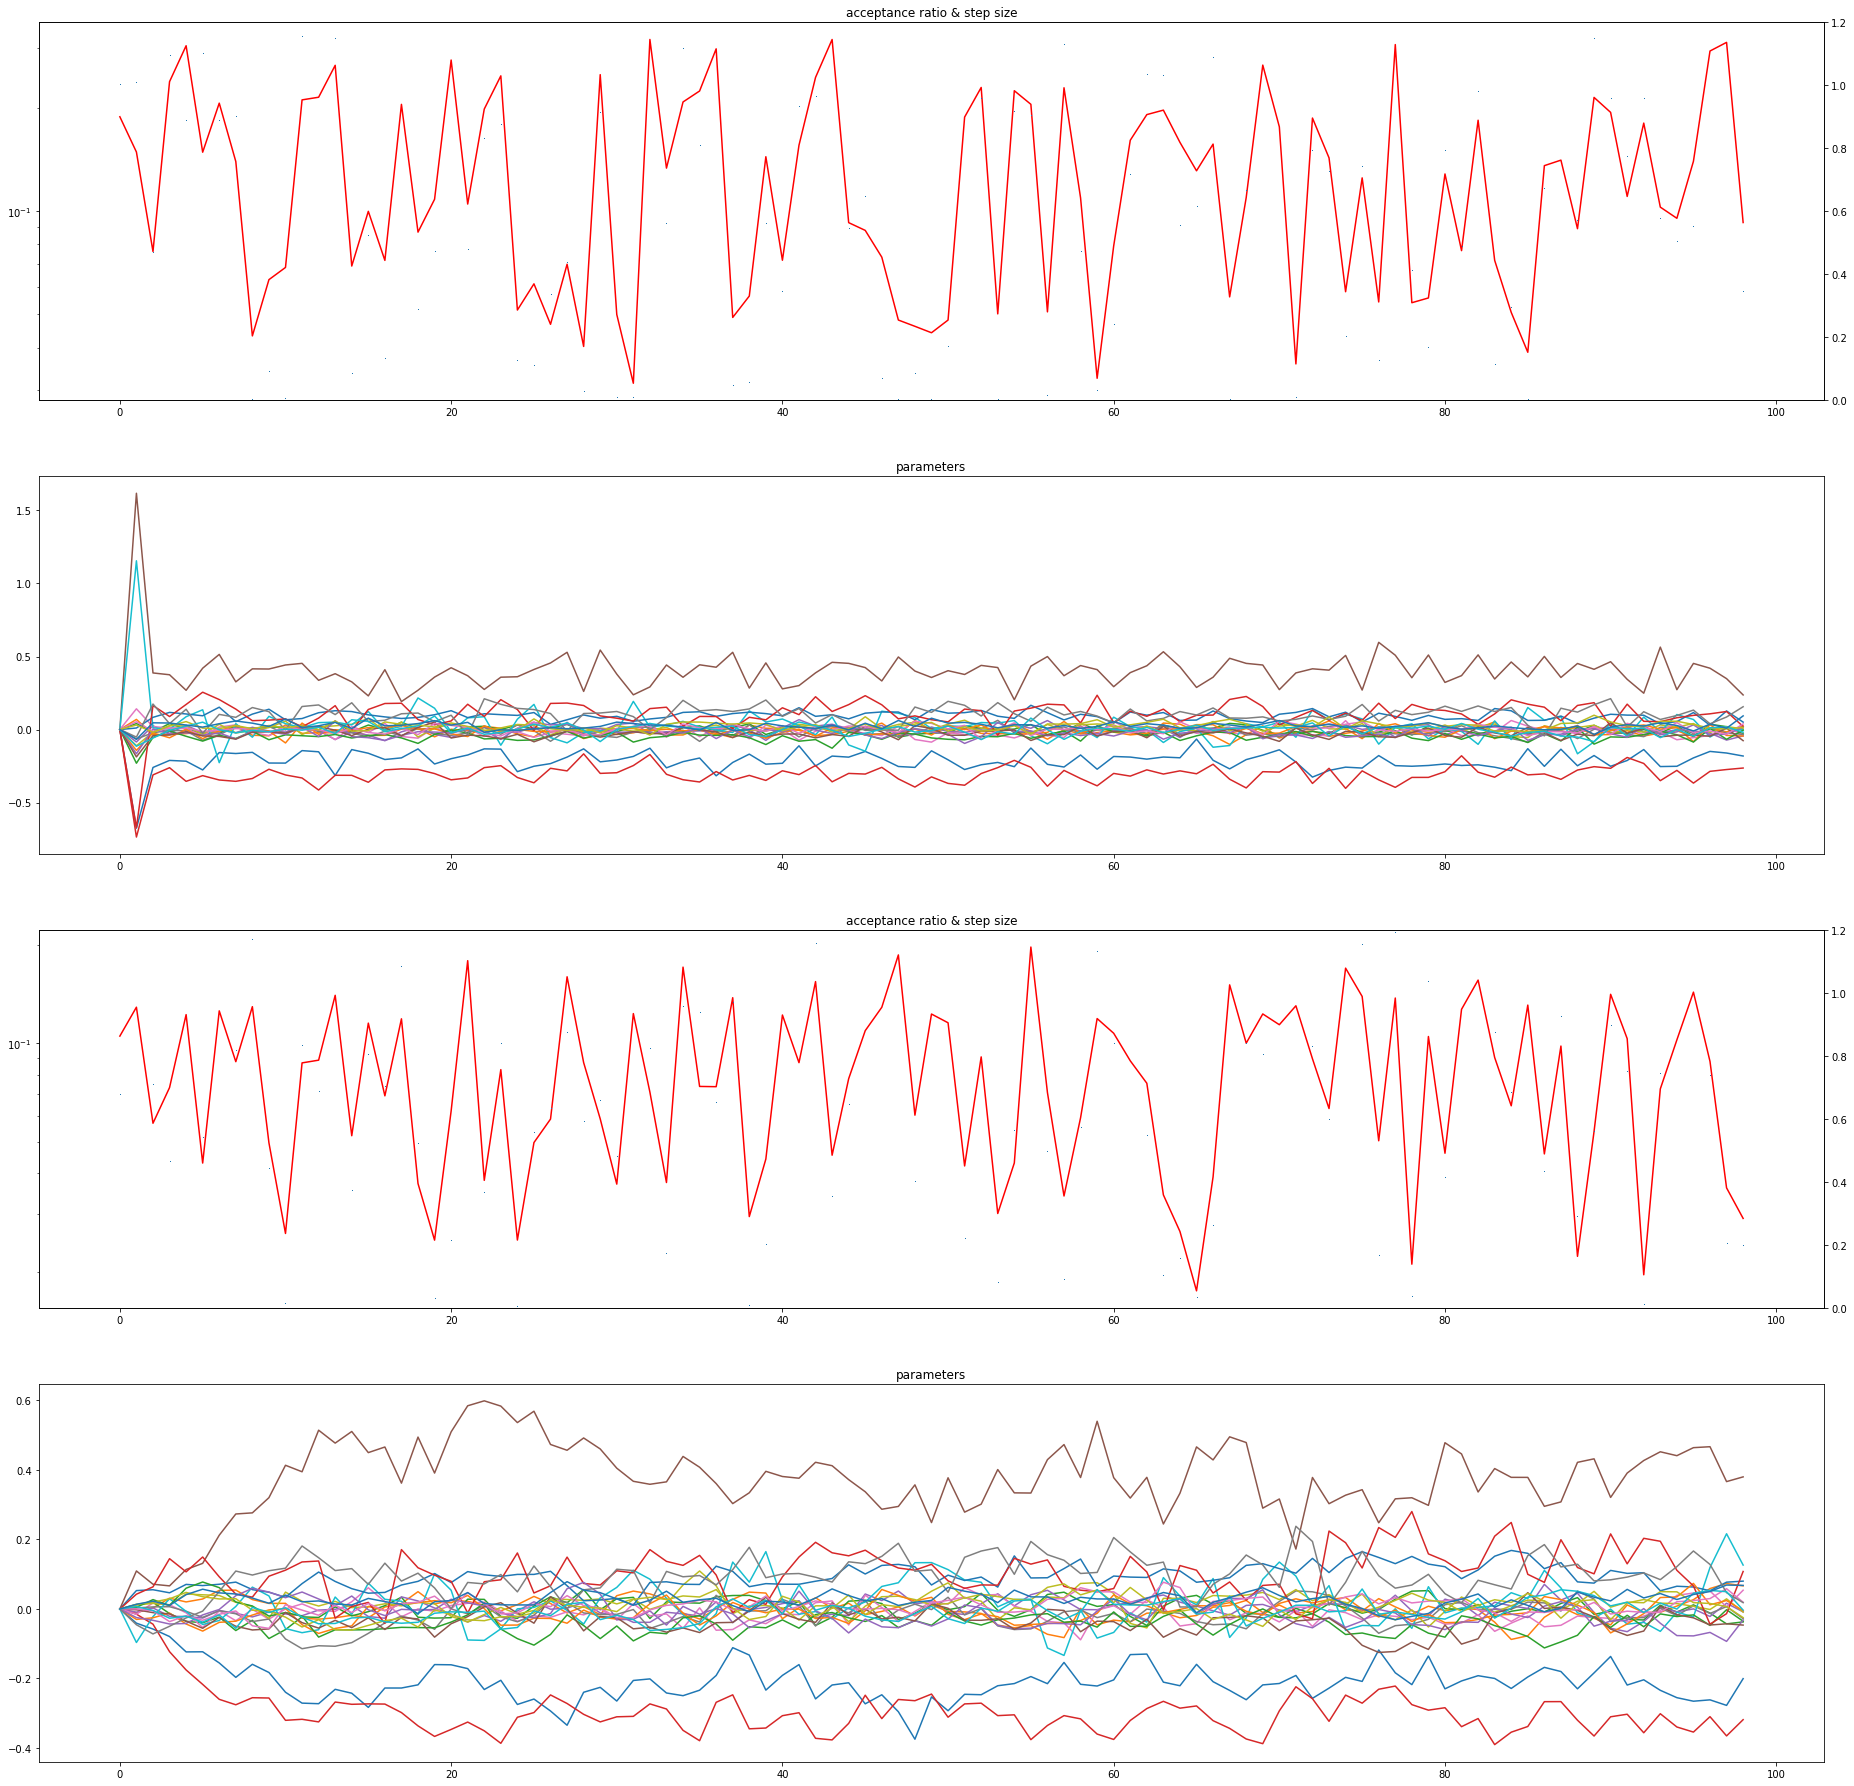

In [15]:
f, k = 0, -1
# f and k are parameters in order to indicate what we should plot : starting at f and ending at k
plot_parameters(samples, samples_exact, f, k)
# Are displayed the parameters and the acceptance ratio every 200 iterations in order to obtain a readable plot

We plot the parameters and acceptance ratio every 200 iterations.
See how there is a first phase where parameters are converging towards the distribution. In future plots we will omit this first phase to only compare methods once converged.

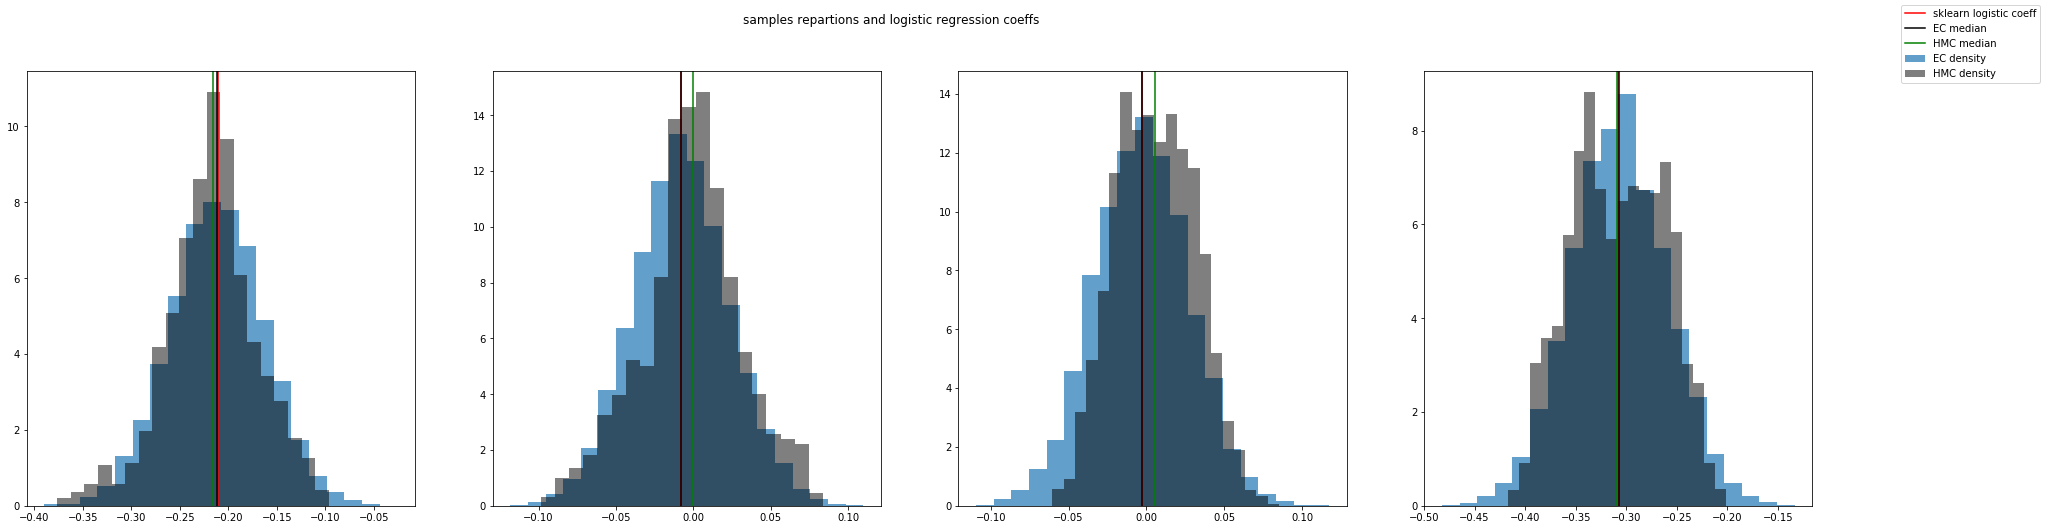

In [16]:
#we also get an idea about what a good sample could be by using Logistic regression.
q_good = LogisticRegression(fit_intercept=False).fit(x, y).coef_

# We take out the first 4 000 iterations where the convergence is not there yet. 
f, k = 4000, -1
plot_distribution(samples, samples_exact, f, k, q_good)

We plot the distribution of samples for the first four parameters, after removing the burn-in period.
Note that the distrubution we obtain with hmc ec is close to the full-dataset hmc.

We can also compare the moments obtained with our method and the ones with standart HMC:

No handles with labels found to put in legend.


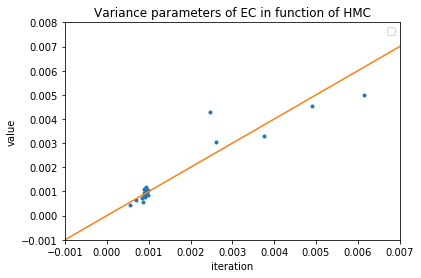

In [17]:
plot_variance(samples, samples_exact)

No handles with labels found to put in legend.


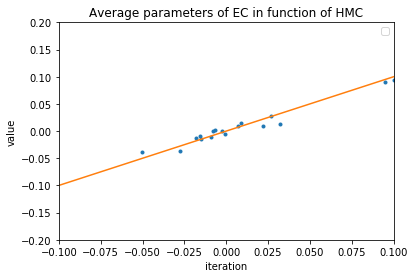

In [18]:
plot_avg(samples, samples_exact)

## Comparing the run-time of HMCEC and HMC
We just saw that for a same number of iterations, HMCEC obtained a similar distribution, for a far lesser time cost.
If we consider a fixed time budget, how does HMCEC compares to HMC ?

In [20]:
# If this cell gives you an error, please re-run it until it works.
%timeit samples = run(*starting_point, 4000, 50,  y, x, shrink, G, lmbda, log_delta, t0, nu, gamma, kappa)


1.06 s ± 167 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%timeit samples_exact = run_exact(*exact_point, 300, 50, y, x, shrink, G, lmbda, log_delta, t0, nu, gamma, kappa)

2.47 s ± 214 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


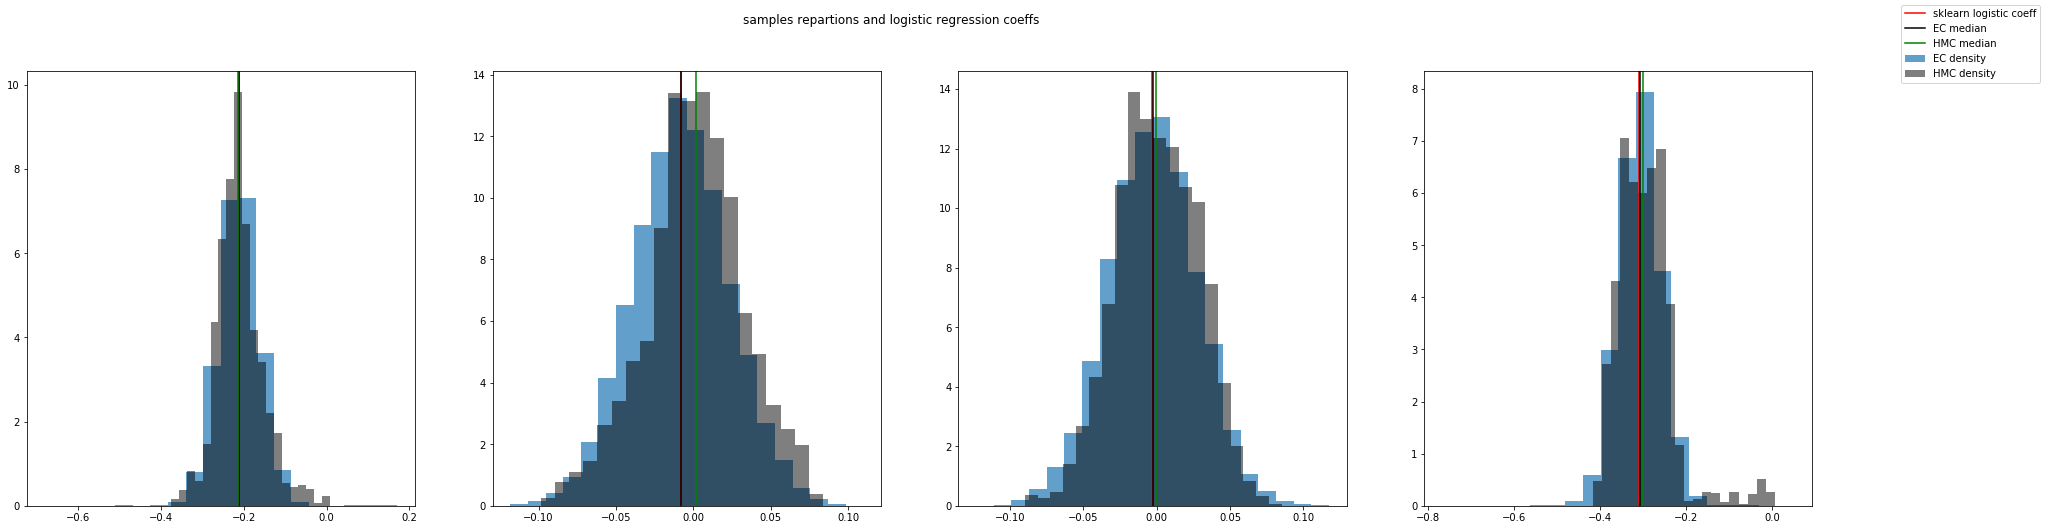

In [22]:
q_good = LogisticRegression(fit_intercept=False).fit(x, y).coef_

ul, ql, el, hl, lgal = samples
ul_e, ql_e, el_e, hl_e, lgal_e = samples_exact

f, k = 0, -1
plot_distribution(samples, samples_exact, f, k, q_good)

Indeed, for the same time budget, the samples obtained using the HMC-EC are far better than the ones with standard HMC.

The iteration cost for the HMC is $O(n)$, while it is $O(m)$ where m is the batch size for the HMCEC. Given that $m=n^{0.5}$ for the difference estimator that is used, we do have experimental speedup matching theoretical ones. 

Finally we can check that the dual averaging is working:

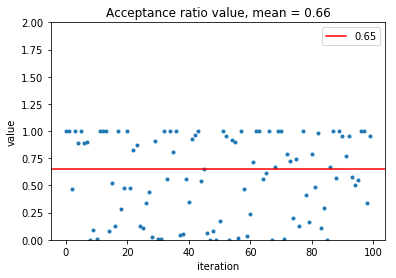

In [23]:
plot_acceptance(samples)

# Conclusion

We implemented the Energy Conservative Hamiltonian Monte Carlo using the difference estimator, and tested it on the higgs dataset, with similar results as the authors. 

# References

[1] The Block Pseudo-Marginal Sampler, M.-N. Tran, R. Kohn, M. Quiroz, M. Villani, 2017 https://arxiv.org/abs/1603.02485

[2] MCMC using Hamiltonian dynamics, Radford M. Neal, 2012 https://arxiv.org/abs/1206.1901

[3] The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo, Matthew D. Hoffman, Andrew Gelman, 2011 https://arxiv.org/abs/1111.4246

[4] Speeding Up MCMC by Efficient Data Subsampling, Matias Quiroz, Robert Kohn, Mattias Villani, Minh-Ngoc Tran, 2018 https://arxiv.org/abs/1404.4178 

[5] The block-Poisson estimator for optimally tuned exact subsampling MCMC, Matias Quiroz, Minh-Ngoc Tran, Mattias Villani, Robert Kohn, Khue-Dung Dang, 2016 https://arxiv.org/abs/1603.08232

[6] On Russian Roulette Estimates for Bayesian Inference with Doubly-Intractable Likelihoods, Anne-Marie Lyne, Mark Girolami, Yves Atchadé, Heiko Strathmann, Daniel Simpson, 2015 https://arxiv.org/abs/1306.4032